# Classification


## 0. Imports

In [1]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Подготовка датасета

### 1.1 Читаем датасет

In [2]:
df = pd.read_csv('datasets/Churn_Modelling.csv')

| Column          | Description                                                                              | Tgt |
|-----------------|------------------------------------------------------------------------------------------|-----|
| RowNumber       | Row Numbers from 1 to 10000                                                              | No  |
| CustomerId      | Unique Ids for bank customer identification                                              | No  |
| Surname         | Customer's last name                                                                     | No  |
| CreditScore     | Credit score of the customer                                                             | No  |
| Geography       | The country from which the customer belongs                                              | No  |
| Gender          | Male or Female                                                                           | No  |
| Age             | Age of the customer                                                                      | No  |
| Tenure          | Number of years for which the customer has been with the bank                            | No  |
| Balance         | Bank balance of the customer                                                             | No  |
| NumOfProducts   | Number of bank products the customer is utilising                                        | No  |
| HasCrCard       | Binary Flag for whether the customer holds a credit card with the bank or not            | No  |
| IsActiveMember  | Binary Flag for whether the customer is an active member with the bank or not            | No  |
| EstimatedSalary | Estimated salary of the customer in Dollars                                              | No  |
| Exited          | Binary flag 1 if the customer closed account with bank and 0 if the customer is retained | Yes |

In [3]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

### 1.2 Кодируем категориальные признаки

In [4]:
from sklearn.preprocessing import OneHotEncoder

categorial = ["Geography", "Gender"]
for col in categorial:
    df[col] = df[col].astype('category')
    df[col]  = df[col].cat.codes
    encoder = OneHotEncoder(sparse=False, categories='auto')
    df_tmp = encoder.fit_transform(df[col].values.reshape(-1, 1))
    df_tmp = df_tmp[:, :-1]
    pd_tmp = pd.DataFrame(df_tmp, columns=['{}_{}'.format(col, i) for i in range(df_tmp.shape[1])])
    df = pd.concat([df, pd_tmp], axis=1)
    
df = df.drop(columns=categorial)
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

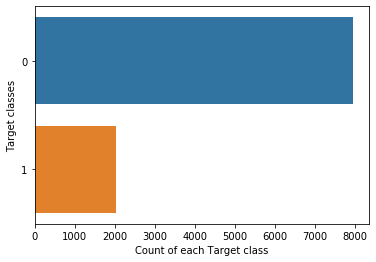

In [5]:
sns.countplot(y=df.Exited ,data=df)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

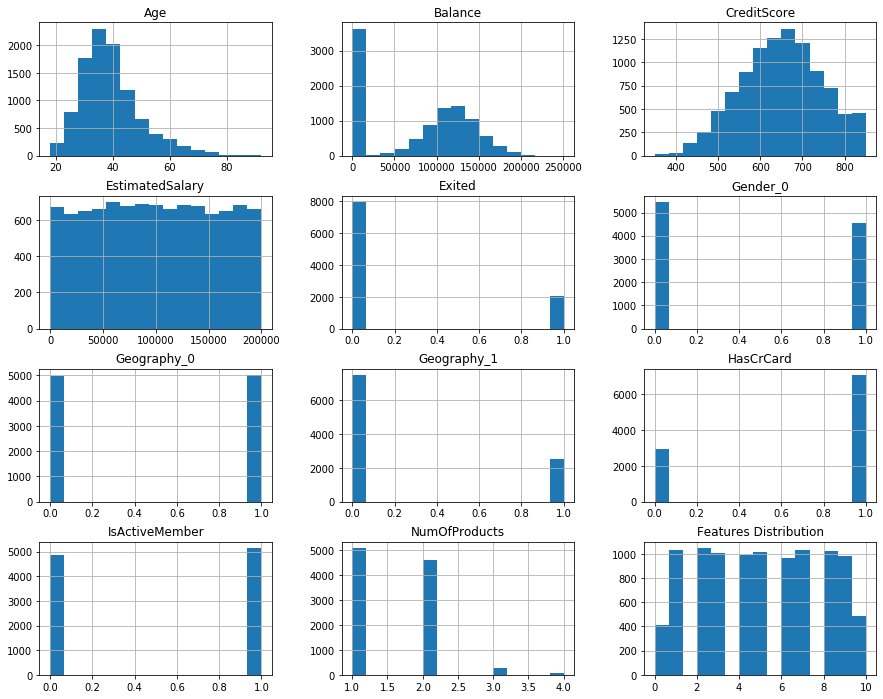

In [6]:
df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

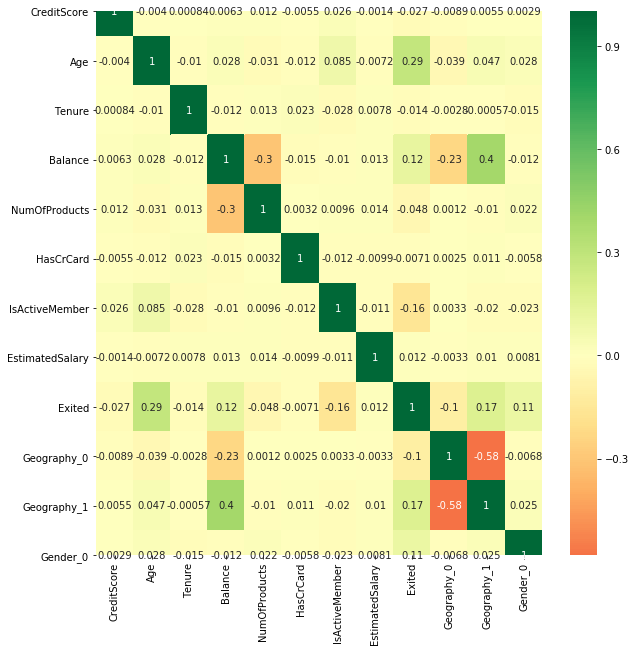

In [7]:
plt.figure(figsize=(10,10))
p=sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', center=0) 

### 1.3 Нормализуем

In [8]:
df = (df-df.min())/(df.max()-df.min())

In [9]:
df.describe()

CreditScore           Age        Tenure       Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000   
mean       0.601058      0.282727      0.501280      0.304848       0.176733   
std        0.193307      0.141727      0.289217      0.248696       0.193885   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.468000      0.189189      0.300000      0.000000       0.000000   
50%        0.604000      0.256757      0.500000      0.387402       0.000000   
75%        0.736000      0.351351      0.700000      0.508749       0.333333   
max        1.000000      1.000000      1.000000      1.000000       1.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  \
count  10000.00000    10000.000000     10000.000000  10000.000000   
mean       0.70550        0.515100         0.500441      0.203700   
std        0.45584        0.499797         0.287580      0.402769   
min        0.00000        0.000000         0.000000      0.000000   
25%        0.00000        0.000000         0.254977      0.000000   
50%        1.00000        1.000000         0.500960      0.000000   
75%        1.00000        1.000000         0.746955      0.000000   
max        1.00000        1.000000         1.000000      1.000000   

        Geography_0   Geography_1      Gender_0  
count  10000.000000  10000.000000  10000.000000  
mean       0.501400      0.250900      0.454300  
std        0.500023      0.433553      0.497932  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        1.000000      0.000000      0.000000  
75%        1.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

### 1.4 Делим на обущающую и тестовую выборки

In [10]:
mask = np.random.rand(len(df)) < 0.7
train = df[mask]
test = df[~mask]

target = "Exited"

train_X = train.drop(columns=[target])
train_y = train[target]

test_X = test.drop(columns=[target])
test_y = test[target]

X_train, y_train, X_test, y_test = train_X, train_y, test_X, test_y

In [11]:
y_train.value_counts()

0.0    5480
1.0    1418
Name: Exited, dtype: int64

In [12]:
y_test.value_counts()

0.0    2483
1.0     619
Name: Exited, dtype: int64

## 2. Обучение

### Создаём класс Random Forest

In [13]:
a = np.array(X_test)
i = np.array([1, 2, 10])
a[:,i]
np.random.choice(11, 1)

array([4])

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.utils.estimator_checks import check_estimator
from scipy import stats


def eval_max_features(n_features, max_features):
    fn = {
        "auto": np.sqrt,
        "sqrt": np.sqrt,
        "log2": np.log2
    }
    if isinstance(max_features, int):
        return int(min(n_features, max_features))
    elif isinstance(max_features, float):
        return int(min(n_features, int(n_features * max_features)))
    elif isinstance(max_features, str):
        return int(fn[max_features](n_features))
    elif max_features is None:
        return int(n_features)
    else:
        raise ValueError()
    

class RandomForestNA(BaseEstimator, ClassifierMixin):
    def __init__(
            self, 
            n_estimators=100,
            criterion='gini',
            max_depth=None,
            class_weight=None,
            max_features='auto'
    ):
        super().__init__()
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.class_weight = class_weight
        self.max_features_fn = max_features
        self.max_depth = max_depth
        
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        self.forest = {}
        
        self.max_features = eval_max_features(X.shape[1], self.max_features_fn) 
        
#         bar = tqdm(total=self.n_estimators)
        for n in range(self.n_estimators):
            columns = np.random.choice(X.shape[1], self.max_features)
            X_sample, _, y_sample, _ = train_test_split(X[:, columns], y, test_size=0.3)
            tree = DecisionTreeClassifier(
                criterion=self.criterion, 
                class_weight=self.class_weight,
                max_features=self.max_features_fn
            ).fit(X_sample, y_sample)
            self.forest[n] = {}
            self.forest[n]["columns"] = columns
            self.forest[n]["tree"] = tree
        
        # Return the classifier
        return self
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        predicts = []
        for tree in self.forest.values():
            predicts.append(tree['tree'].predict(X[:, tree['columns']]))
#         predicts = np.ndarray(predicts)
        pred = stats.mode(predicts)
        return pred.mode.T
    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        
        predicts = []
        for tree in self.forest.values():
            predicts.append(tree['tree'].predict_proba(X[:, tree['columns']]))
#         predicts = np.ndarray(predicts)
        pred = np.mean(np.array(predicts), axis=0)
        return pred
    def get_params(self, deep=True):
    # suppose this estimator has parameters "alpha" and "recursive"
        return {
            "n_estimators": self.n_estimators,
            "criterion": self.criterion,
            "class_weight": self.class_weight
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# check_estimator(RandomForestNA)

### Параметры моделей

In [15]:
models = {
    "logreg": {
        "estimator": LogisticRegression,
        "best": None,
        "score": 0,
        "params": {
            "n_jobs": [-1],
            "C": [0.1, 1, 10, 100],
            "class_weight": [None, 'balanced'],
            "max_iter": [10000],
            "solver": ['lbfgs']
        }
    },
    "nb": {
        "estimator": GaussianNB,
        "best": None,
        "score": 0,
        "params": {
        }
    },
    "svm": {
        "estimator": SVC,
        "best": None,
        "score": 0,
        "params": {
            "C": [0.1, 1, 10, 100],
            "class_weight": [None, 'balanced'],
            "gamma": ["auto"],
            "kernel": ["poly", "rbf", "linear"],
            "max_iter": [10000],
            "probability": [True]
        }
    },
    "rf": {
        "estimator": RandomForestNA,
        "best": None,
        "score": 0,    
        "params": {
            "n_estimators": [25, 50, 100, 1000],
            "criterion": ["gini", "entropy"],
            "class_weight": [None, 'balanced'],
            "max_features": ["auto", "sqrt"],
            "max_depth": [5, 10, None]
        }
    }
}

### Поиск лучших параметров

In [16]:
bar = tqdm(total=len(models))
for name, model in models.items():
    model["best"] = GridSearchCV(model["estimator"](), cv=5, param_grid=model["params"], verbose=10, n_jobs=8).fit(X_train, y_train)
    bar.update(1)
bar.close()

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  30 out of  40 | elapsed:    3.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  35 out of  40 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    3.1s finished
 25%|██▌       | 1/4 [00:03<00:09,  3.22s/it][Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.0389s.) Setting batch_size=10.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.0s
[Paralle

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   29.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   43.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   54.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 118 out of 120 | elapsed:  3.3min remaining:    3.4s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:  3.4min finished
/home/oberon/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Convergenc

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.4s
/home/oberon/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   19.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   23.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   31.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   37.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   47.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   53.4s
[Parallel(n_jobs=8)]: Done 129 tasks     

## 3. Оценка результата

### Строим ROC AUC

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.784
Logistic regression: ROC AUC=0.758
SVM: ROC AUC=0.804
Random Forest: ROC AUC=0.820


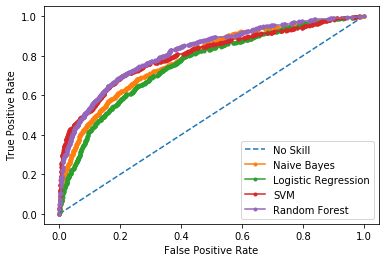

In [17]:
nb = models["nb"]["best"]
lr = models["logreg"]["best"]
svm = models["svm"]["best"]
rf = models["rf"]["best"]

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)

nb_probs = nb.predict_proba(X_test)
nb_probs = nb_probs[:, 1]
nb_auc = roc_auc_score(y_test, nb_probs)

lr_probs = lr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)

svm_probs = svm.predict_proba(X_test)
svm_probs = svm_probs[:, 1]
svm_auc = roc_auc_score(y_test, svm_probs)

rf_probs = rf.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic regression: ROC AUC=%.3f' % (lr_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

### Accuracy, Precision, Recall

In [18]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, matthews_corrcoef, f1_score

In [19]:
nb_y_pred = nb.predict(test_X)
lr_y_pred = lr.predict(test_X)
svm_y_pred = svm.predict(test_X)
rf_y_pred = rf.predict(test_X)

In [20]:
nb_p = precision_score(test_y, nb_y_pred)
lr_p = precision_score(test_y, lr_y_pred)
svm_p = precision_score(test_y, svm_y_pred)
rf_p = precision_score(test_y, rf_y_pred)

nb_a = accuracy_score(test_y, nb_y_pred)
lr_a = accuracy_score(test_y, lr_y_pred)
svm_a = accuracy_score(test_y, svm_y_pred)
rf_a = accuracy_score(test_y, rf_y_pred)

nb_r = recall_score(test_y, nb_y_pred)
lr_r = recall_score(test_y, lr_y_pred)
svm_r = recall_score(test_y, svm_y_pred)
rf_r = recall_score(test_y, rf_y_pred)

nb_f = f1_score(test_y, nb_y_pred)
lr_f = f1_score(test_y, lr_y_pred)
svm_f = f1_score(test_y, svm_y_pred)
rf_f = f1_score(test_y, rf_y_pred)

nb_m = matthews_corrcoef(test_y, nb_y_pred)
lr_m = matthews_corrcoef(test_y, lr_y_pred)
svm_m = matthews_corrcoef(test_y, svm_y_pred)
rf_m = matthews_corrcoef(test_y, rf_y_pred)

In [28]:
print('Naive Bayes:')
print('\tprecision = %.3f' % (nb_p))
print('\taccuracy  = %.3f' % (nb_a))
print('\trecall    = %.3f' % (nb_r))
print('\tf1        = %.3f' % (nb_f))
print('\tMCC       = %.3f' % (nb_m))
print()
print('Logistic Regression:')
print('\tprecision = %.3f' % (lr_p))
print('\taccuracy  = %.3f' % (lr_a))
print('\trecall    = %.3f' % (lr_r))
print('\tf1        = %.3f' % (lr_f))
print('\tMCC       = %.3f' % (lr_m))
print()
print('SVM:')
print('\tprecision = %.3f' % (svm_p))
print('\taccuracy  = %.3f' % (svm_a))
print('\trecall    = %.3f' % (svm_r))
print('\tf1        = %.3f' % (svm_f))
print('\tMCC       = %.3f' % (svm_m))
print()
print('Random Forest:')
print('\tprecision = %.3f' % (rf_p))
print('\taccuracy  = %.3f' % (rf_a))
print('\trecall    = %.3f' % (rf_r))
print('\tf1        = %.3f' % (rf_f))
print('\tMCC       = %.3f' % (rf_m))

Naive Bayes:
	precision = 0.607
	accuracy  = 0.825
	recall    = 0.347
	f1        = 0.442
	MCC       = 0.366

Logistic Regression:
	precision = 0.587
	accuracy  = 0.812
	recall    = 0.202
	f1        = 0.300
	MCC       = 0.263

SVM:
	precision = 0.811
	accuracy  = 0.857
	recall    = 0.367
	f1        = 0.505
	MCC       = 0.482

Random Forest:
	precision = 0.716
	accuracy  = 0.840
	recall    = 0.330
	f1        = 0.451
	MCC       = 0.411


In [32]:
for name, model in models.items():
    print("Best {} model is %s", name, model["best"])

Best %s model is %s logreg GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [10000], 'n_jobs': [-1],
                         'solver': ['lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbos